In [1]:
%cd ../

/home/gramos/Projects/MIIA-A23/code/mercury-duckling


In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from PIL import Image
import cv2
import torch
from torchvision import tv_tensors
from torchvision.datasets import CocoDetection
import torchvision.transforms.v2 as v2
from torchvision.transforms.v2.functional import to_pil_image
from torchvision.datasets import wrap_dataset_for_transforms_v2
from mercury_duckling.datasets.transforms import (
    Blobify,
    OneHotEncodeFromBlobs,
    ResizeLongestSideAndPad,
    Colormap,
    MinMaxNormalization,
    StandardizeTarget
)
from mercury_duckling.datasets import ThermalDataset

/home/gramos/.pyenv/versions/3.11.5/envs/thermal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/gramos/.pyenv/versions/3.11.5/envs/thermal/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
transform = None
target_transform = None
transforms = v2.Compose(
    [
        v2.ToImage(),
        # v2.RandomZoomOut(fill={tv_tensors.Image: (0), "others": 0}),
        # v2.RandomIoUCrop(),
        # v2.RandomHorizontalFlip(p=0.7),
        # ResizeByCoefficient(cfg.data.coeff),
        # MinMaxNormalization(),
        # Colormap(colormap="turbo"),
        # Blobify(),
        # OneHotEncodeFromBlobs(),
        ResizeLongestSideAndPad(target_size=(256, 320)),
        # v2.ClampBoundingBoxes(),
        v2.ToDtype({tv_tensors.Image: torch.float32, "others": None}, scale=False),
    ]
)
root="../../data/merged_dataset_delam_thm"
dataset = ThermalDataset(
    root=root,
    annFile=os.path.join(root, "annotations/delamination.json"),
    transform=transform,
    target_transform=target_transform,
    transforms=transforms,
)
dataset = wrap_dataset_for_transforms_v2(
    dataset,
    target_keys=["masks", "labels", "boxes", "image_id"]
)
root="../../data/merged_dataset_concrete"
dataset_concrete = CocoDetection(
    root=root,
    annFile=os.path.join(root, "annotations/concrete.json"),
    transform=transform,
    target_transform=target_transform,
    transforms=transforms,
)
dataset_concrete = wrap_dataset_for_transforms_v2(
    dataset_concrete,
    target_keys=["masks", "labels", "boxes", "image_id"]
)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [4]:
idx = 255
input, target = dataset[idx]
print("Image ID:", target["image_id"])
print(
    "input shape:", input.shape, 
    "\ninput class:", type(input),
    "\ninput dtype:", input.dtype
)
print(
    "\ntarget shape:", target["masks"].shape,
    "\nnumber of targets:", len(target["boxes"]),
    "\ntarget class:", type(target["masks"]),
    "\ntarget dtype:", target["masks"].dtype
)

Image ID: 256
input shape: torch.Size([1, 256, 320]) 
input class: <class 'torchvision.tv_tensors._image.Image'> 
input dtype: torch.float32

target shape: torch.Size([1, 256, 320]) 
number of targets: 1 
target class: <class 'torchvision.tv_tensors._mask.Mask'> 
target dtype: torch.uint8


In [5]:
def get_visible(file_name, vis_dataset):
    vis_name = file_name.replace("IR", "VIS")
    for _, img_info in vis_dataset.coco.imgs.items():
        if img_info["file_name"] == vis_name:
            return img_info["id"]

file_name = dataset.coco.imgs[idx + 1]["file_name"]
print(file_name.replace("IR", "VIS"))
vis_input, vis_target = dataset_concrete[get_visible(file_name, dataset_concrete) - 1]

VIS04_37.jpg


In [42]:
def interpolate(subBin, LU, RU, LB, RB, subX, subY):
    """
    Image interpolation function, need to be applied after CLAHE
    """
    subImage = np.zeros(subBin.shape)
    num = subX * subY
    for i in range(subX):
        inverseI = subX - i
        for j in range(subY):
            inverseJ = subY - j
            val = subBin[i, j].astype(int)
            subImage[i, j] = np.floor(
                (inverseI * (inverseJ * LU[val] + j * RU[val]) + i * (inverseJ * LB[val] + j * RB[val])) / float(num))
    return subImage


def clahe(img, clipLimit, nrBins=128, nrX=0, nrY=0):
    """
    CLAHE algorithm implementation

    :param img: Input image
    :param clipLimit: Normalized clipLimit. Higher value gives more contrast
    :param nrBins: Number of gray level bins for histogram("dynamic range")
    :param nrX: Number of contextual regions in X direction
    :param nrY: Number of contextual regions in Y direction
    """
    h, w = img.shape
    if clipLimit == 1:
        return
    nrBins = max(nrBins, 128)
    if nrX == 0:
        # Taking dimensions of each contextial region to be a square of 32X32
        xsz = 32
        ysz = 32
        nrX = np.ceil(h / xsz)  # 240
        # Excess number of pixels to get an integer value of nrX and nrY
        excX = int(xsz * (nrX - h / xsz))
        nrY = np.ceil(w / ysz)  # 320
        excY = int(ysz * (nrY - w / ysz))
        # Pad that number of pixels to the image
        if excX != 0:
            img = np.append(img, np.zeros((excX, img.shape[1])).astype(int), axis=0)
        if excY != 0:
            img = np.append(img, np.zeros((img.shape[0], excY)).astype(int), axis=1)
    else:
        xsz = np.round(h / nrX)
        ysz = np.round(w / nrY)
        excX = int(xsz * (nrX - h / xsz))
        excY = int(ysz * (nrY - w / ysz))
        if excX != 0:
            img = np.append(img, np.zeros((excX, img.shape[1])).astype(int), axis=0)
        if excY != 0:
            img = np.append(img, np.zeros((img.shape[0], excY)).astype(int), axis=1)

    nrPixels = xsz * ysz
    claheimg = np.zeros(img.shape)

    if clipLimit > 0:
        clipLimit = max(1, clipLimit * xsz * ysz / nrBins)
    else:
        clipLimit = 50

    # Making LUT
    print("...Make the LUT...")
    minVal = 0  # np.min(img)
    maxVal = 255  # np.max(img)

    binSz = np.floor(1 + (maxVal - minVal) / float(nrBins))
    LUT = np.floor((np.arange(minVal, maxVal + 1) - minVal) / float(binSz))

    # Creating bins from LUT with image
    bins = LUT[img]
    print(bins.shape)

    # Making Histogram
    print("...Making the Histogram...")
    nrX = int(nrX)
    nrY = int(nrY)
    xsz = int(xsz)
    ysz = int(ysz)
    hist = np.zeros((nrX, nrY, nrBins))
    print(nrX, nrY, hist.shape)
    for i in range(nrX):
        for j in range(nrY):
            bin_ = bins[i * xsz:(i + 1) * xsz, j * ysz:(j + 1) * ysz].astype(int)
            for i1 in range(xsz):
                for j1 in range(ysz):
                    hist[i, j, bin_[i1, j1]] += 1

    # Clipping Histogram
    print("...Clipping the Histogram...")
    if clipLimit > 0:
        for i in range(nrX):
            for j in range(nrY):
                nrExcess = 0
                for nr in range(nrBins):
                    excess = hist[i, j, nr] - clipLimit
                    if excess > 0:
                        nrExcess += excess

                binIncr = nrExcess / nrBins
                upper = clipLimit - binIncr
                for nr in range(nrBins):
                    if hist[i, j, nr] > clipLimit:
                        hist[i, j, nr] = clipLimit
                    else:
                        if hist[i, j, nr] > upper:
                            nrExcess += upper - hist[i, j, nr]
                            hist[i, j, nr] = clipLimit
                        else:
                            nrExcess -= binIncr
                            hist[i, j, nr] += binIncr

                if nrExcess > 0:
                    stepSz = max(1, np.floor(1 + nrExcess / nrBins))
                    for nr in range(nrBins):
                        nrExcess -= stepSz
                        hist[i, j, nr] += stepSz
                        if nrExcess < 1:
                            break

    # Mapping Histogram
    print("...Mapping the Histogram...")
    map_ = np.zeros((nrX, nrY, nrBins))
    # print(map_.shape)
    scale = (maxVal - minVal) / float(nrPixels)
    for i in range(nrX):
        for j in range(nrY):
            sum_ = 0
            for nr in range(nrBins):
                sum_ += hist[i, j, nr]
                map_[i, j, nr] = np.floor(min(minVal + sum_ * scale, maxVal))

    # Interpolation
    print("...Interpolation...")
    xI = 0
    for i in range(nrX + 1):
        if i == 0:
            subX = int(xsz / 2)
            xU = 0
            xB = 0
        elif i == nrX:
            subX = int(xsz / 2)
            xU = nrX - 1
            xB = nrX - 1
        else:
            subX = xsz
            xU = i - 1
            xB = i

        yI = 0
        for j in range(nrY + 1):
            if j == 0:
                subY = int(ysz / 2)
                yL = 0
                yR = 0
            elif j == nrY:
                subY = int(ysz / 2)
                yL = nrY - 1
                yR = nrY - 1
            else:
                subY = ysz
                yL = j - 1
                yR = j
            UL = map_[xU, yL, :]
            UR = map_[xU, yR, :]
            BL = map_[xB, yL, :]
            BR = map_[xB, yR, :]

            subBin = bins[xI:xI + subX, yI:yI + subY]

            subImage = interpolate(subBin, UL, UR, BL, BR, subX, subY)
            claheimg[xI:xI + subX, yI:yI + subY] = subImage
            yI += subY
        xI += subX

    if excX == 0 and excY != 0:
        return claheimg[:, :-excY]
    elif excX != 0 and excY == 0:
        return claheimg[:-excX, :]
    elif excX != 0 and excY != 0:
        return claheimg[:-excX, :-excY]
    else:
        return claheimg


In [49]:
cmap = Colormap(colormap="Greys")
# ROI Scaling
inpt_greyscale = np.array(to_pil_image(cmap(input)[1, ...] * vis_target["masks"][0]))
# CLAHE Processing
clahe_image = clahe(inpt_greyscale, 10, 256, 4, 4)

...Make the LUT...
(256, 320)
...Making the Histogram...
4 4 (4, 4, 256)
...Clipping the Histogram...
...Mapping the Histogram...
...Interpolation...


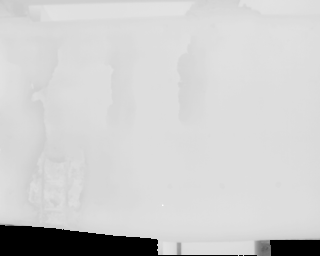

In [50]:
display(Image.fromarray(inpt_greyscale.astype(np.uint8)))

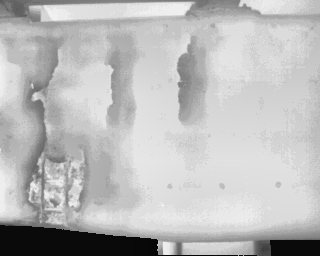

In [51]:
display(Image.fromarray(clahe_image.astype(np.uint8)))